In [64]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.feature_selection import SelectFromModel, f_regression
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, LabelEncoder
import researchpy as rp 

from sklearn import set_config
set_config(display="diagram") #setting this will display your pipelines as seen above

import warnings
warnings.filterwarnings("ignore")


# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In the automotive industry, accurately predicting used car sales prices is crucial for dealerships, sellers, and buyers alike. Understanding the factors that influence the pricing of used cars can lead to better pricing strategies, improved inventory management, and enhanced customer satisfaction. This project aims to develop a predictive model following the Cross-Industry Standard Process for Data Mining (CRISP-DM) framework to forecast the sales prices of used cars based on various attributes.

Objective: The primary objective of this project is to develop and compare different models (Linear Regression, Lasso and Ridge Regression) that can predict the sales prices of used cars with high accuracy based on various factors. This model will assist stakeholders, including dealerships and individual sellers, in setting competitive and realistic prices for their vehicles. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

Data Source: Data used in the analysis were obtained from Kaggle (N=426880). Kaggle is a data science competition platform and online community of data scientists and machine learning practitioners under Google LLC. It enables users to find and publish datasets, explore and build models in a web-based data science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.[1] 

Missing Data: Since statistical modelling requires a complete data set in which the target and feature variables were recorded (complete case analysis), observations with missing values (incomplete cases) were excluded from the analysis (listwise deletion). High rates of missing data can result into biased and misleading conclusions in data analysis. Also, duplicated records based on VIN were excluded from the analysis. 

Inclusion Criteria: No inclusion criterion was adopted. 

Target: price 

Features: Features/independent variables were either directly used as is or derived. Car model was concatenated with manufacturing to create a variable 'man_model'. Categorical variables/features were categorized based on their count and then encoded to create dummies for categories with significant counts (e.g. if >= 1000, the category was encoded as is else encoded as 'other') using a one-hot encoder in Python. Below are the thresholds used for each categorical variable: ('state', 1000), ('manufacturer', 1000), ('man_model', 100), ('region', 250), ('condition', 0), ('cylinders', 0), ('fuel', 0), ('title_status', 0), ('size', 0), ('drive', 0), ('type', 500), ('paint_color', 800), ('transmission', 0)

Features that are categorized as identifiers (e.g. id and VIN) were excluded from the analysis. Also, since car dealerships are interested in making profits, cars valued at zero were excluded from the analysis leaving 20,715 records for our analysis.


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [65]:
car = pd.read_csv("C:/Users/Luswata/Dropbox/ML_AI_UCBerkeley/Data/vehicles.csv", sep = ',')
car.shape

(426880, 18)

In [66]:
# car

In [67]:
car.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [68]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [69]:
# count records with price ==0 and drop them

# Count records where price == 0
count_zeros = (car['price'] == 0).sum()
print(f"Number of records where price == 0: {count_zeros}")

# Drop records where price <= 0
car_nonzero = car[car['price'] > 0]

# Verify that records with price == 0 are dropped
count_zeros_after_drop = (car_nonzero['price'] <= 0).sum()
print(f"After dropping, number of records where price <= 0: {count_zeros_after_drop}")


Number of records where price == 0: 32895
After dropping, number of records where price <= 0: 0


In [70]:
# EXPLORE MISSINGNESS
# Drop records with NaN in ALL the specified columns

# List of columns to check for NaN values
columns_to_check = ['year', 'manufacturer', 'model', 'condition', 'cylinders',
                    'fuel', 'odometer', 'title_status', 'transmission',
                    'drive', 'size', 'type']

# Drop records with NaN values in specified columns where all specified columns are NaN
car_cleaned = car_nonzero.dropna(subset=columns_to_check, how='all')

# Check if there are any NaN values left in the cleaned DataFrame
remaining_nan = car_nonzero.isna().sum()
print(f"Remaining NaN values after cleaning:\n{remaining_nan}")

# Print summary
print(f"Original dataset shape: {car_nonzero.shape}")
print(f"Cleaned dataset shape: {car_cleaned.shape}")


Remaining NaN values after cleaning:
id                   0
region               0
price                0
year              1173
manufacturer     16185
model             4701
condition       151389
cylinders       160410
fuel              2594
odometer          2290
title_status      7734
transmission      1823
VIN             152158
drive           120254
size            282933
type             85932
paint_color     117149
state                0
dtype: int64
Original dataset shape: (393985, 18)
Cleaned dataset shape: (393923, 18)


In [71]:
# List of variables to compute missing percentage for 
vars = ['size', 'condition','cylinders', 'paint_color','drive','type', 'title_status', 'manufacturer', 'fuel', 'model', 'odometer', 'transmission' ]

# Loop over each variable to compute percent missingness and keep only those with > 5% missingness
selected_vars = []
for column_name in vars:
    missing_percentage = (car_cleaned[column_name].isnull().sum() / len(car_cleaned)) * 100
    if missing_percentage > 1:
        selected_vars.append(column_name)
        print(f"The percentage of missing values in column '{column_name}' is: {missing_percentage:.2f}%")

The percentage of missing values in column 'size' is: 71.81%
The percentage of missing values in column 'condition' is: 38.42%
The percentage of missing values in column 'cylinders' is: 40.71%
The percentage of missing values in column 'paint_color' is: 29.72%
The percentage of missing values in column 'drive' is: 30.51%
The percentage of missing values in column 'type' is: 21.80%
The percentage of missing values in column 'title_status' is: 1.95%
The percentage of missing values in column 'manufacturer' is: 4.09%
The percentage of missing values in column 'model' is: 1.18%


In [72]:
print(car_cleaned.shape)

# Drop records with ANY NaN values in any column
car_cleaned = car_cleaned.dropna(how='any')
print(car_cleaned.shape)

(393923, 18)
(32496, 18)


In [73]:
# Identify any duplicated records based on 'VIN'. Linear regression depends on independence of the target variable
print(car_cleaned.shape)

duplicated = car_cleaned.duplicated(subset=['VIN'], keep='first')

# Drop duplicated records
car_nodup = car_cleaned[~duplicated]
print(car_nodup.shape)


(32496, 18)
(20715, 18)


In [74]:
# Drop identifier variables
columns_to_drop = ['id', 'VIN']
car_nodup = car_nodup.drop(columns=columns_to_drop)


In [75]:
car_nodup

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
215,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,fwd,compact,sedan,blue,al
219,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,rwd,mid-size,sedan,white,al
268,birmingham,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,rwd,compact,convertible,white,al
337,birmingham,8950,2011.0,ford,f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,fwd,full-size,truck,white,al
338,birmingham,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,rwd,full-size,coupe,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426660,wyoming,24999,2014.0,ford,"f150, platinum",excellent,6 cylinders,gas,147540.0,clean,automatic,4wd,full-size,pickup,grey,wy
426661,wyoming,8999,2014.0,chevrolet,"cruze, 2lt",excellent,4 cylinders,gas,105930.0,clean,automatic,fwd,full-size,sedan,white,wy
426673,wyoming,5200,2005.0,subaru,legacy,good,4 cylinders,gas,172511.0,clean,automatic,4wd,mid-size,sedan,blue,wy
426737,wyoming,2500,2005.0,honda,civic,good,4 cylinders,gas,185000.0,clean,manual,fwd,compact,sedan,grey,wy


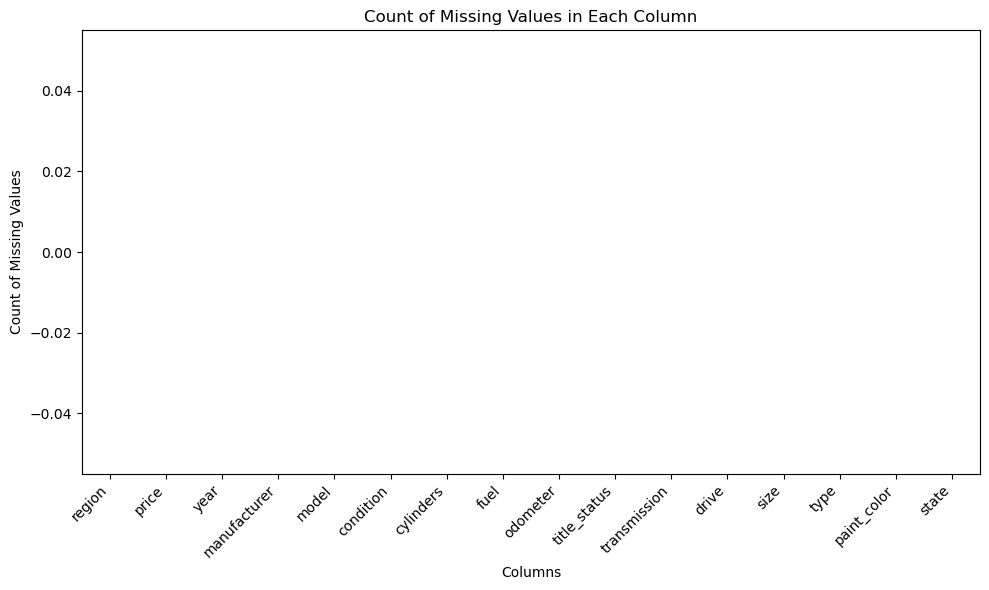

In [76]:
# Check misingness rates 
missing_values_count = car_nodup.isnull().sum().sort_values()

plt.figure(figsize=(10, 6))
missing_values_count.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Count of Missing Values')
plt.title('Count of Missing Values in Each Column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot (optional)
plt.show()

In [77]:
nan_count = car_nodup['size'].isna().sum()
print(f"Number of NaN values in 'size': {nan_count}")

rp.summary_cat(car_nodup['size'])

Number of NaN values in 'size': 0


,Variable,Outcome,Count,Percent
0,size,full-size,11270,54.41
1,,mid-size,6362,30.71
2,,compact,2668,12.88
3,,sub-compact,415,2.00


In [78]:
df = car_nodup

In [79]:
df.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [80]:
# Count unique values in each categorical column
unique_counts = df.select_dtypes(include=['object']).nunique()

print("Number of unique values:")
print(unique_counts)

Number of unique values:
region           378
manufacturer      41
model           4850
condition          6
cylinders          8
fuel               5
title_status       6
transmission       3
drive              3
size               4
type              13
paint_color       12
state             51
dtype: int64


In [81]:
rp.summary_cat(df['paint_color'])

,Variable,Outcome,Count,Percent
0,paint_color,white,4950,23.90
1,,black,3801,18.35
2,,silver,3160,15.25
3,,grey,2684,12.96
4,,blue,2184,10.54
5,,red,1937,9.35
6,,custom,568,2.74
7,,green,565,2.73
8,,brown,537,2.59
9,,yellow,160,0.77


In [82]:
# rp.summary_cat(df['model'])

In [83]:
# Concatenate 'manufacturer' and 'model' with a hyphen
df['man_model'] = df['manufacturer'] + '-' + df['model']

# Drop 'model' column
df.drop(['model'], axis=1, inplace=True)
#df

In [84]:
df_orig = df

In [85]:
# ENCODE CATEGORICAL VARIABLES

def encode_categorical(df, column, threshold):
    """
    Encode categorical variable in DataFrame df based on a frequency threshold.
    
    Parameters:
    - df: DataFrame containing the categorical variable.
    - column: Name of the categorical column to encode.
    - threshold: Frequency threshold to determine categories to keep.
    
    Returns:
    - df_encoded: DataFrame with categorical variable encoded using one-hot encoding.
    """
    # Calculate frequencies of each category in the specified column
    column_counts = df[column].value_counts()
    
    # Identify categories with count > threshold and categorize the rest as 'other'
    categories_to_keep = column_counts[column_counts > threshold].index.tolist()
    df[column + '_category'] = df[column].apply(lambda x: x if x in categories_to_keep else 'otther')
    
    # One-hot encoding of the categorical variable
    encoded_df = pd.get_dummies(df[column + '_category'], prefix=column, dtype=float)

     # Concatenate original DataFrame and encoded DataFrame
    df_encoded = pd.concat([df, encoded_df], axis=1)
    
    # Drop the original column and the categorical category column if needed
    #df_encoded.drop([column, column + '_category'], axis=1, inplace=True)
    df_encoded.drop([column], axis=1, inplace=True)
    
    return df_encoded

# Example usage
# Assuming df is your DataFrame and you want to encode 'state', 'manufacturer', 'model', etc.
# Replace df with your actual DataFrame and adjust column names as needed

# Encode 'state' with count > 1000, categorize others as 'other'
df_encoded = encode_categorical(df, 'state', 1000)

# Encode 'manufacturer' with count > 1000, categorize others as 'other'
df_encoded = encode_categorical(df_encoded, 'manufacturer', 1000)

# Encode 'model' with count > 100, categorize others as 'other'
df_encoded = encode_categorical(df_encoded, 'man_model', 100)

# Encode 'region' with count > 250, categorize others as 'other'
df_encoded = encode_categorical(df_encoded, 'region', 250)

# Encode 'condition' with count >0, categorize others as 'other'
df_encoded = encode_categorical(df_encoded, 'condition', 0)

# Encode 'cylinders' with count > 0, categorize others as 'other'
df_encoded = encode_categorical(df_encoded, 'cylinders', 0)

# Encode 'fuel' with count > 0, categorize others as 'other'
df_encoded = encode_categorical(df_encoded, 'fuel', 0)

# Encode 'title_status' with count > 0, categorize others as 'other'
df_encoded = encode_categorical(df_encoded, 'title_status', 0)

# Encode 'size' with count > 0, categorize others as 'other'
df_encoded = encode_categorical(df_encoded, 'size', 0)

# Encode 'drive' with count > 0, categorize others as 'other'
df_encoded = encode_categorical(df_encoded, 'drive', 0)

# Encode 'type' with count > 500, categorize others as 'other'
df_encoded = encode_categorical(df_encoded, 'type', 500)

# Encode 'paint_color' with count > 800, categorize others as 'other'
df_encoded = encode_categorical(df_encoded, 'paint_color', 800)

# Encode 'transmission' with count > 0, categorize others as 'other'
df_encoded = encode_categorical(df_encoded, 'transmission', 0)


# Display the final encoded DataFrame
df_encoded.head(5)


,price,year,odometer,state_category,state_ca,state_fl,state_ny,state_otther,manufacturer_category,manufacturer_chevrolet,...,paint_color_blue,paint_color_grey,paint_color_otther,paint_color_red,paint_color_silver,paint_color_white,transmission_category,transmission_automatic,transmission_manual,transmission_other
215,4000,2002.0,155000.0,otther,0.0,0.0,0.0,1.0,toyota,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,automatic,1.0,0.0,0.0
219,2500,1995.0,110661.0,otther,0.0,0.0,0.0,1.0,otther,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,automatic,1.0,0.0,0.0
268,9000,2008.0,56700.0,otther,0.0,0.0,0.0,1.0,otther,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,automatic,1.0,0.0,0.0
337,8950,2011.0,164000.0,otther,0.0,0.0,0.0,1.0,ford,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,automatic,1.0,0.0,0.0
338,4000,1972.0,88100.0,otther,0.0,0.0,0.0,1.0,otther,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,automatic,1.0,0.0,0.0


In [86]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20715 entries, 215 to 426833
Columns: 105 entries, price to transmission_other
dtypes: float64(91), int64(1), object(13)
memory usage: 16.8+ MB


In [87]:
# PRIOR TO ENCODING
rp.summary_cat(df['fuel'])

,Variable,Outcome,Count,Percent
0,fuel,gas,19272,93.03
1,,diesel,1069,5.16
2,,hybrid,290,1.40
3,,electric,57,0.28
4,,other,27,0.13


In [88]:
# POST ENCODING

fuel_columns = [col for col in df_encoded.columns if col.startswith('fuel_')]
print(fuel_columns)

# Loop through variables and print their counts
for col in fuel_columns:
    summary = rp.summary_cat(df_encoded[col])
    print(f"Summary for column {col}:")
    print(summary)
    print("\n")


['fuel_category', 'fuel_diesel', 'fuel_electric', 'fuel_gas', 'fuel_hybrid', 'fuel_other']
Summary for column fuel_category:
        Variable   Outcome  Count  Percent
0  fuel_category       gas  19272    93.03
1                   diesel   1069     5.16
2                   hybrid    290     1.40
3                 electric     57     0.28
4                    other     27     0.13


Summary for column fuel_diesel:
      Variable  Outcome  Count  Percent
0  fuel_diesel      0.0  19646    94.84
1                   1.0   1069     5.16


Summary for column fuel_electric:
        Variable  Outcome  Count  Percent
0  fuel_electric      0.0  20658    99.72
1                     1.0     57     0.28


Summary for column fuel_gas:
   Variable  Outcome  Count  Percent
0  fuel_gas      1.0  19272    93.03
1                0.0   1443     6.97


Summary for column fuel_hybrid:
      Variable  Outcome  Count  Percent
0  fuel_hybrid      0.0  20425     98.6
1                   1.0    290      1.4


Sum

In [89]:
rp.summary_cat(df['paint_color'])

,Variable,Outcome,Count,Percent
0,paint_color,white,4950,23.90
1,,black,3801,18.35
2,,silver,3160,15.25
3,,grey,2684,12.96
4,,blue,2184,10.54
5,,red,1937,9.35
6,,custom,568,2.74
7,,green,565,2.73
8,,brown,537,2.59
9,,yellow,160,0.77


In [90]:
# List columns with prefix 'paint_color_'
paint_columns = [col for col in df_encoded.columns if col.startswith('paint_color_')]
print(paint_columns)

# Loop through state columns and print summary using rp.summary_cat
for col in paint_columns:
    summary = rp.summary_cat(df_encoded[col])
    print(f"Summary for column {col}:")
    print(summary)
    print("\n")

['paint_color_category', 'paint_color_black', 'paint_color_blue', 'paint_color_grey', 'paint_color_otther', 'paint_color_red', 'paint_color_silver', 'paint_color_white']
Summary for column paint_color_category:
               Variable Outcome  Count  Percent
0  paint_color_category   white   4950    23.90
1                         black   3801    18.35
2                        silver   3160    15.25
3                          grey   2684    12.96
4                          blue   2184    10.54
5                        otther   1999     9.65
6                           red   1937     9.35


Summary for column paint_color_black:
            Variable  Outcome  Count  Percent
0  paint_color_black      0.0  16914    81.65
1                         1.0   3801    18.35


Summary for column paint_color_blue:
           Variable  Outcome  Count  Percent
0  paint_color_blue      0.0  18531    89.46
1                        1.0   2184    10.54


Summary for column paint_color_grey:
           Var

In [91]:
#rp.summary_cat(df['model'])

In [92]:
(car.shape, car_cleaned.shape, df_encoded.shape) 

((426880, 18), (32496, 18), (20715, 105))

In [93]:
# Display the final encoded DataFrame
df_encoded.head(5)

,price,year,odometer,state_category,state_ca,state_fl,state_ny,state_otther,manufacturer_category,manufacturer_chevrolet,...,paint_color_blue,paint_color_grey,paint_color_otther,paint_color_red,paint_color_silver,paint_color_white,transmission_category,transmission_automatic,transmission_manual,transmission_other
215,4000,2002.0,155000.0,otther,0.0,0.0,0.0,1.0,toyota,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,automatic,1.0,0.0,0.0
219,2500,1995.0,110661.0,otther,0.0,0.0,0.0,1.0,otther,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,automatic,1.0,0.0,0.0
268,9000,2008.0,56700.0,otther,0.0,0.0,0.0,1.0,otther,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,automatic,1.0,0.0,0.0
337,8950,2011.0,164000.0,otther,0.0,0.0,0.0,1.0,ford,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,automatic,1.0,0.0,0.0
338,4000,1972.0,88100.0,otther,0.0,0.0,0.0,1.0,otther,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,automatic,1.0,0.0,0.0


In [94]:
# Re-check for columns with missing values or NaNs
columns_with_missing = df_encoded.columns[df_encoded.isna().any()].tolist()

# Print columns with missing values
print(f"Columns with missing values or NaNs: {columns_with_missing}")

Columns with missing values or NaNs: []


In [95]:
df = df_encoded

Shapiro-Wilk Test - Test Statistic: 0.8102936744689941, p-value: 0.0


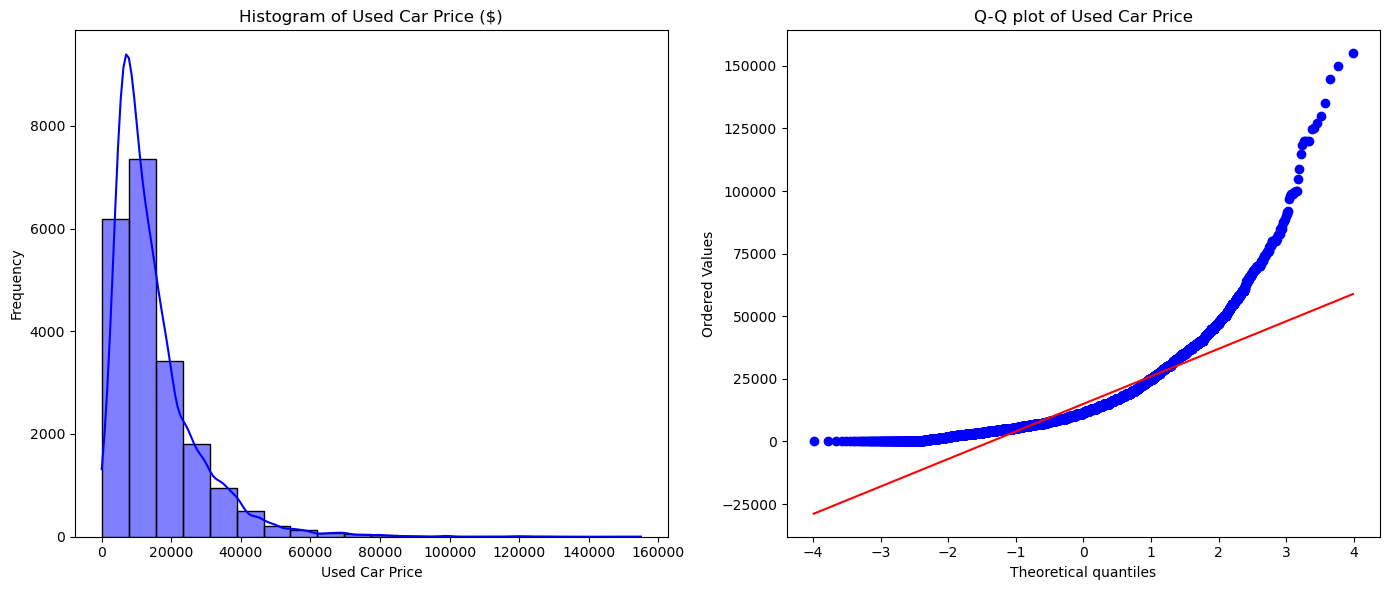

In [96]:
# TEST OF NORMALITY OF THE TARGET VARIABLE
# The Shapiro-Wilk test assesses whether the distribution of the data differs from a normal distribution.

# Extract the y variable
y = df["price"]

# Shapiro-Wilk test for normality
shapiro_test_statistic, shapiro_p_value = stats.shapiro(y)
print(f'Shapiro-Wilk Test - Test Statistic: {shapiro_test_statistic}, p-value: {shapiro_p_value}')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram of y variable
sns.histplot(y, kde=True, color='blue', bins=20, ax=ax1)
ax1.set_title('Histogram of Used Car Price ($)')
ax1.set_xlabel('Used Car Price')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(y, dist="norm", plot=ax2)
ax2.set_title('Q-Q plot of Used Car Price')
ax2.set_xlabel('Theoretical quantiles')
ax2.set_ylabel('Ordered Values')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Price is positively skewed. Does not follow a normal distribution.


In [97]:
# Find columns with NaN values
columns_with_nan = df.columns[df.isnull().any()].tolist()

print("Columns with NaN values:")
print(columns_with_nan)

Columns with NaN values:
[]


In [98]:
rp.summary_cat(df['region_category'])

,Variable,Outcome,Count,Percent
0,region_category,otther,19267,93.01
1,,vermont,332,1.60
2,,minneapolis / st paul,317,1.53
3,,central NJ,273,1.32
4,,colorado springs,265,1.28
5,,omaha / council bluffs,261,1.26


In [99]:
data_type = df['region_category'].dtype

print(f"Data type of df['region_category']: {data_type}")

Data type of df['region_category']: object


In [100]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns to label encode
columns_to_encode = ['region_category', 'manufacturer_category', 'man_model_category', 'condition_category',
                     'cylinders_category', 'fuel_category', 'title_status_category', 'transmission_category',
                     'drive_category', 'size_category', 'type_category', 'paint_color_category', 'state_category']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each column and label encode
for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])


In [101]:
data_type = df['region_category'].dtype

print(f"Data type of df['region_category']: {data_type}")

Data type of df['region_category']: int32


In [102]:
# Identify any categorical variables (dtype = object) to drop
categorical_vars = df.select_dtypes(include=['object']).columns.tolist()

# Print the list of categorical variables
print("Categorical variables in the dataset:")
print(categorical_vars)

Categorical variables in the dataset:
[]


In [103]:
df.drop(columns=categorical_vars, inplace=True)

In [104]:
# BEST TRANSFORMATION FOR OUR TARGET VARIABLES

X = df[['region_category', 'year', 'manufacturer_category', 'man_model_category', 'condition_category',
        'cylinders_category', 'fuel_category', 'odometer', 'title_status_category', 'transmission_category',
        'drive_category', 'size_category', 'type_category', 'paint_color_category', 'state_category']]
y = df['price']

# Define different transformations
transformations = ['log', 'sqrt', 'boxcox', 'reciprocal']

best_score = -np.inf
best_transformation = None
best_model = None

for transformation in transformations:
    # Apply transformation to the target variable
    if transformation == 'log':
        y_transformed = np.log(y)
    elif transformation == 'sqrt':
        y_transformed = np.sqrt(y)
    elif transformation == 'boxcox':
        y_transformed, _ = stats.boxcox(y)
    elif transformation == 'reciprocal':
        y_transformed = 1 / y
#    elif transformation == 'exp':
 #       y_transformed = np.exp(y)
    
    # Fit linear regression model
    model = LinearRegression().fit(X, y_transformed)
    
    # Evaluate model performance
    y_pred_transformed = model.predict(X)
    score = r2_score(y_transformed, y_pred_transformed)
    
    # Update best transformation if necessary
    if score > best_score:
        best_score = score
        best_transformation = transformation
        best_model = model

print("Best transformation:", best_transformation)
print("Best R-squared score:", best_score)


Best transformation: sqrt
Best R-squared score: 0.3450223873610222


In [105]:
# List columns containing 'category' in their name
columns_to_drop = [col for col in df.columns if 'category' in col.lower()]

# Print the columns to be dropped
print("Columns containing 'category' in their name:")
print(columns_to_drop)

# Drop columns from the DataFrame
df.drop(columns=columns_to_drop, inplace=True)


Columns containing 'category' in their name:
['state_category', 'manufacturer_category', 'man_model_category', 'region_category', 'condition_category', 'cylinders_category', 'fuel_category', 'title_status_category', 'size_category', 'drive_category', 'type_category', 'paint_color_category', 'transmission_category']


In [106]:
# Square root transformation of 'price'
df['price_sqrt'] = np.sqrt(df['price'])

In [107]:
# df['price_sqrt'].describe()
df

,price,year,odometer,state_ca,state_fl,state_ny,state_otther,manufacturer_chevrolet,manufacturer_ford,manufacturer_honda,...,paint_color_blue,paint_color_grey,paint_color_otther,paint_color_red,paint_color_silver,paint_color_white,transmission_automatic,transmission_manual,transmission_other,price_sqrt
215,4000,2002.0,155000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,63.245553
219,2500,1995.0,110661.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,50.000000
268,9000,2008.0,56700.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,94.868330
337,8950,2011.0,164000.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,94.604440
338,4000,1972.0,88100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,63.245553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426660,24999,2014.0,147540.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,158.110721
426661,8999,2014.0,105930.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,94.863059
426673,5200,2005.0,172511.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,72.111026
426737,2500,2005.0,185000.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,50.000000


Shapiro-Wilk Test - Test Statistic: 0.9647074937820435, p-value: 0.0


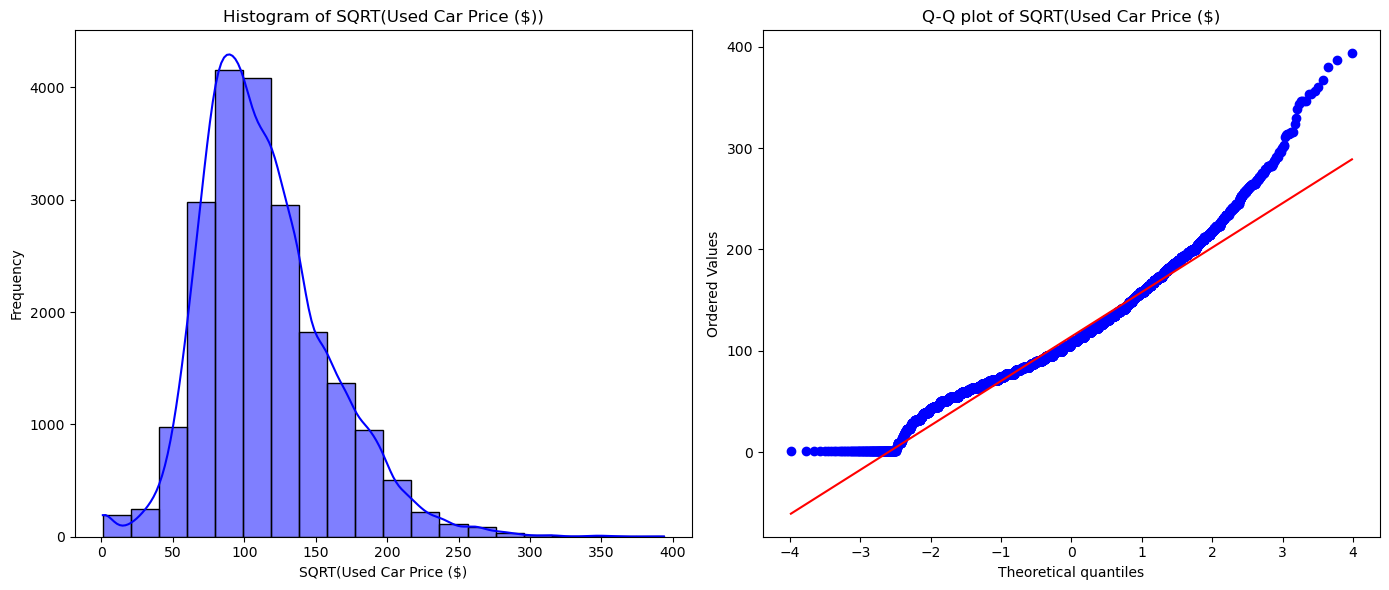

In [108]:
# TEST OF NORMALITY OF THE TARGET VARIABLE
# The Shapiro-Wilk test assesses whether the distribution of the data differs from a normal distribution.

# Extract the y variable
y = df["price_sqrt"]

# Shapiro-Wilk test for normality
shapiro_test_statistic, shapiro_p_value = stats.shapiro(y)
print(f'Shapiro-Wilk Test - Test Statistic: {shapiro_test_statistic}, p-value: {shapiro_p_value}')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram of y variable
sns.histplot(y, kde=True, color='blue', bins=20, ax=ax1)
ax1.set_title('Histogram of SQRT(Used Car Price ($))')
ax1.set_xlabel('SQRT(Used Car Price ($)')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(y, dist="norm", plot=ax2)
ax2.set_title('Q-Q plot of SQRT(Used Car Price ($)')
ax2.set_xlabel('Theoretical quantiles')
ax2.set_ylabel('Ordered Values')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


The Shapiro-Wilk Test Statistic value, 𝑊=0.965, closer to 1 indicates that the sample data deviates slightly from a perfect normal distribution. The data is approximately normally distributed. The p-value, 𝑝=0.0 (𝑝<0.001), indicates strong evidence against the null hypothesis of normality.

In [109]:
# Define continuous variables to summarize
continuous_vars = ['price', 'price_sqrt']

# Function to compute summary statistics for a given column
def compute_summary_stats(df, column_name):
    summary_stats = {
        'min': df[column_name].min(),    
        'p1': df[column_name].quantile(0.01),
        'q1': np.percentile(df[column_name], 25),        
        'mean': df[column_name].mean(),
        'std_dev': df[column_name].std(),
        'median': df[column_name].median(),
        'q3': np.percentile(df[column_name], 75),
        'p95': df[column_name].quantile(0.95),
        'max': df[column_name].max()
    }
    return summary_stats

# Loop over each variable, compute summary stats, and print
for var in continuous_vars:
    summary_stats = compute_summary_stats(df, var)
    summary_df = pd.DataFrame(summary_stats, index=[var])
    # Round values to 3 decimal places
    summary_df = summary_df.round(2)
    print(f"Summary statistics for {var}:")
    print(summary_df)
    print()

Summary statistics for price:
       min     p1      q1      mean   std_dev   median       q3      p95  \
price    1  499.0  6950.0  15003.17  12221.56  11500.0  18999.0  38000.0   

          max  
price  155000  

Summary statistics for price_sqrt:
            min     p1     q1    mean  std_dev  median      q3     p95    max
price_sqrt  1.0  22.34  83.37  114.05    44.68  107.24  137.84  194.94  393.7



Since prices less than or equal to zero were excluded from the analysis, the summary statistics show that prices range widely, from a minimum of 1 to a maximum of 155,000.0. The mean price of 15,003.17 is influenced by the wide dispersion indicated by the standard deviation (12,221.56). The median price (11,500.0) is lower than the mean, suggesting a potential skewness towards lower-priced vehicles.

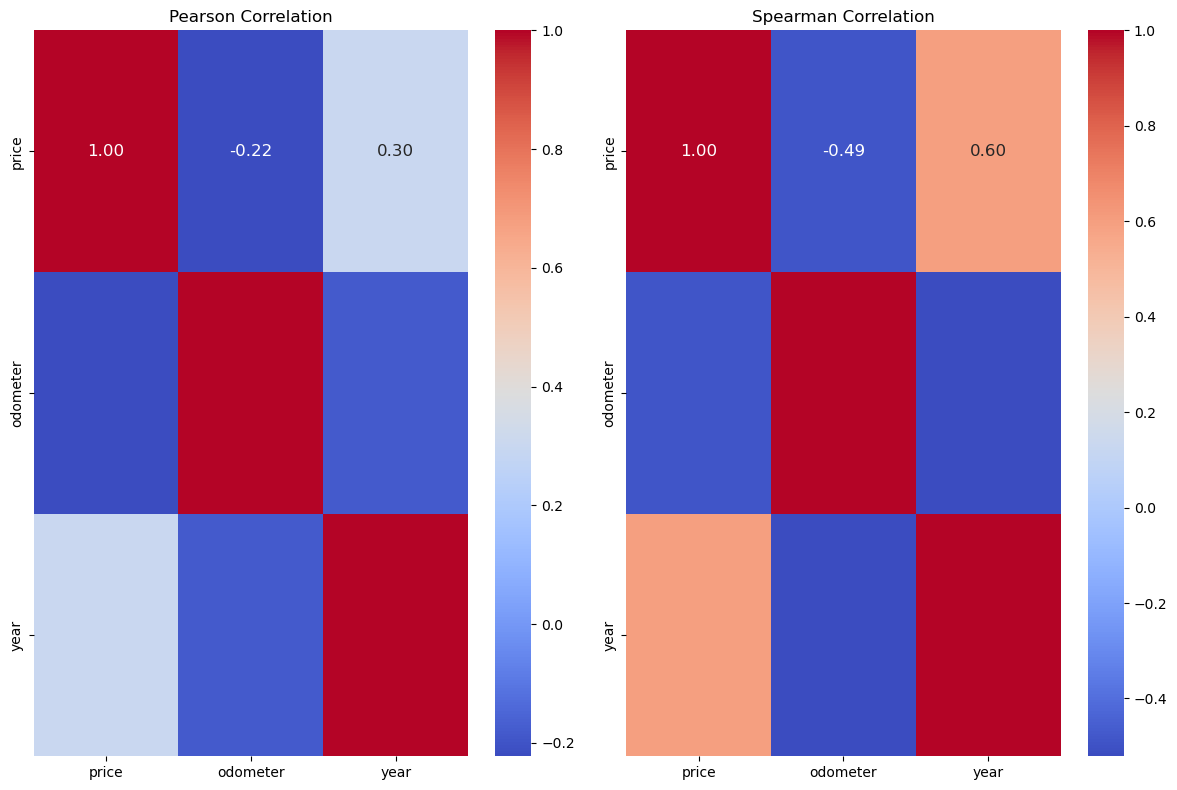

In [110]:
# Visualize correlations
# Select specific columns of interest
cols_of_interest = ['price', 'odometer', 'year']

# Calculate correlation matrix (Pearson and Spearman)
correlation_matrix_pearson = car_nodup[cols_of_interest].corr(method='pearson')
correlation_matrix_spearman = car_nodup[cols_of_interest].corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(12, 8))

# Heatmap for Pearson correlations
plt.subplot(1, 2, 1)
sns.heatmap(correlation_matrix_pearson, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
plt.title('Pearson Correlation')

# Heatmap for Spearman correlations
plt.subplot(1, 2, 2)
sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
plt.title('Spearman Correlation')

plt.tight_layout()
plt.show()


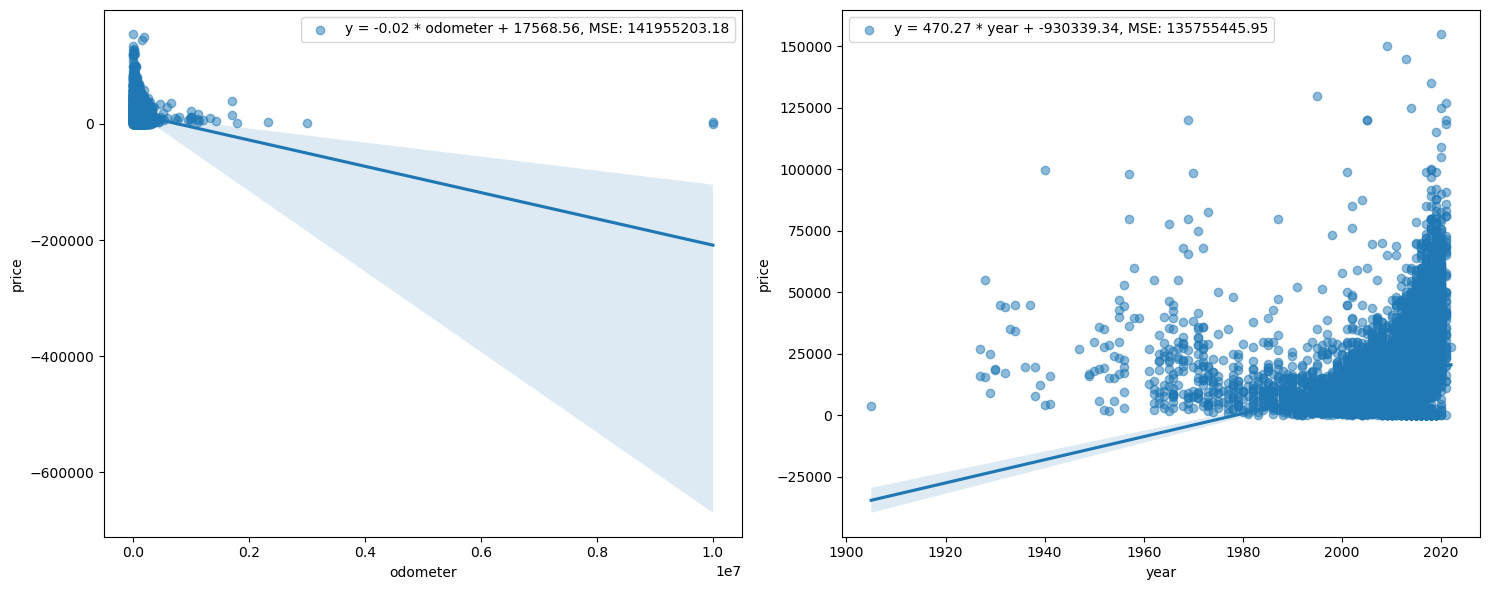

In [111]:
from sklearn.impute import SimpleImputer

# Visualize relationships between features and target
X = car_nodup[['odometer', 'year']]
y = car_nodup['price']

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Create subplots for each predictor
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()

# Plot each predictor against y with regression line
for i, predictor in enumerate(X.columns):
    sns.regplot(x=predictor, y=y, data=df, ax=axes[i], scatter_kws={'alpha':0.5})
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_imputed[:, i].reshape(-1, 1), y)
    
    # Make predictions
    predictions = model.predict(X_imputed[:, i].reshape(-1, 1))
    
    # Calculate and display Mean Squared Error (MSE)
    mse = mean_squared_error(y, predictions)
    
    # Get slope (m) and intercept (b) of the regression line
    m = model.coef_[0]
    b = model.intercept_
    
    # Add equation to legend
    equation = f'y = {m:.2f} * {predictor} + {b:.2f}, MSE: {mse:.2f}'
    axes[i].legend([equation])

plt.tight_layout()
plt.show()


Based on the plots and the Shapiro-Wilk test results, it seems there are indications that the data may have outlying records that could affect its distribution and statistical properties. Identifying and verifying outliers in data is crucial for ensuring the validity and reliability of statistical analyses and models.

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [112]:
# Split data into training and testing sets
X = df.drop(columns=['price', 'price_sqrt'])
y = df['price_sqrt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16572, 91) (4143, 91) (16572,) (4143,)


In [113]:
# measure of collinearity using VIF
def vif(exogs, df):
    vif_dict = {}

    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = df[not_exog], df[exog]

        r_squared = LinearRegression().fit(X,y).score(X,y)

        # calculate VIF
        vif = 1/(1-r_squared)
        vif_dict[exog] = vif

    return pd.DataFrame({"VIF": vif_dict})

In [114]:
vif(X.columns, X).sort_values(by = 'VIF', ascending = False)

,VIF
condition_excellent,inf
state_ca,inf
size_mid-size,inf
size_full-size,inf
size_compact,inf
...,...
man_model_ford-f-150,inf
man_model_ford-explorer,inf
man_model_ford-escape,inf
year,1.431993


Features with a VIF value > 10 (high multicollinearity) will be retained for RIDGE regression to handle. Ridge regression is specifically designed to handle multicollinearity by adding a penalty to the size of regression coefficients, thus reducing their sensitivity to correlated predictors.

In [115]:
# Permutation Importance
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

r = permutation_importance(lr_model, X_test, y_test, random_state=123)
r.importances_mean

array([ 2.20680379e-01,  5.49108185e-02,  2.88195056e-03,  3.84890215e-03,
        1.38679129e-04,  1.14399816e-03, -3.94044181e-05,  2.81354378e-04,
        1.45223019e-04,  3.07715679e-03, -4.77777373e-06,  1.48863782e-03,
        2.11009045e-06,  1.07929069e-03,  3.51441832e-04,  4.20741450e-04,
        1.01709119e-05, -1.90179670e-05,  5.29167340e-04,  1.63521059e-05,
       -4.46074184e-06,  1.04730380e-04,  1.41365774e-04,  5.97081746e-05,
        2.97882162e-03, -1.98051322e-06,  3.57930757e-04,  6.94088544e-04,
        6.65594907e-04, -1.63485404e-05,  2.20718598e-04,  2.52352794e-04,
        2.74696434e-04,  7.49933594e-04,  7.27090648e-04,  8.55605213e-05,
        2.24220711e-04,  4.11584500e-05,  7.86201056e-06,  2.07481051e-03,
        1.05619349e-02,  1.97026543e-02,  8.95377364e-03,  3.65930332e-02,
        7.80587180e-03,  8.98852334e-04,  4.51428721e-03,  2.24903216e-04,
        1.82024775e-04,  3.21395950e-03,  3.92945314e-04,  7.40372207e-04,
        3.09119454e-02,  

In [116]:
# r.importances

In [117]:
importance_tuples = list(zip(X.columns, r.importances_mean))
sorted_importance_tuples = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_importance_tuples:
    print(feature, importance)

year 0.22068037872330998
odometer 0.054910818543706205
type_sedan 0.03687222100025835
condition_like new 0.03659303316458575
cylinders_8 cylinders 0.03091194539736939
fuel_diesel 0.024250341960131937
drive_fwd 0.023423873861672818
condition_fair 0.01970265430912299
transmission_manual 0.012809557747143785
type_truck 0.012577813998418152
fuel_gas 0.012102996107293373
condition_excellent 0.010561934913014959
drive_4wd 0.010520705033956568
condition_good 0.008953773638348239
type_coupe 0.008919602077133137
transmission_other 0.008844141392125814
type_SUV 0.008594086664057875
condition_new 0.00780587179957255
type_hatchback 0.007100025434076307
type_otther 0.006455145065441248
type_convertible 0.006283538184177995
size_full-size 0.0059174026838420875
cylinders_10 cylinders 0.00451428720988023
state_fl 0.0038489021539469537
cylinders_4 cylinders 0.003213959498946006
transmission_automatic 0.003107908793680325
manufacturer_nissan 0.003077156792696667
man_model_jeep-wrangler 0.002978821621339

In [118]:
# Filter features with importance < 0
selected_features = [feature for feature, importance in importance_tuples if importance < 0]

# Print selected features
print("Selected features with importance < 0:")
print(selected_features)

Selected features with importance < 0:
['manufacturer_chevrolet', 'manufacturer_otther', 'man_model_ford-f-150', 'man_model_honda-accord', 'man_model_nissan-altima', 'man_model_toyota-camry', 'fuel_other', 'title_status_missing', 'paint_color_blue', 'paint_color_otther', 'paint_color_red']


In [119]:
# Drop the non-important features
df = df.drop(columns=selected_features)

In [120]:
# Split data into training and testing sets
X = df.drop(columns=['price', 'price_sqrt'])
y = df['price_sqrt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16572, 80) (4143, 80) (16572,) (4143,)


In [121]:
#df.info()

In [126]:
# df.columns

In [127]:
X = ['year', 'odometer', 'state_ca', 'state_fl', 'state_ny',
       'state_otther', 'manufacturer_ford', 'manufacturer_honda',
       'manufacturer_nissan', 'manufacturer_toyota',
       'man_model_chevrolet-equinox', 'man_model_chevrolet-silverado 1500',
       'man_model_chevrolet-silverado 2500hd', 'man_model_ford-escape',
       'man_model_ford-explorer', 'man_model_ford-mustang',
       'man_model_gmc-sierra 1500', 'man_model_honda-civic',
       'man_model_honda-cr-v', 'man_model_jeep-grand cherokee',
       'man_model_jeep-wrangler', 'man_model_otther', 'man_model_ram-1500',
       'man_model_ram-2500', 'man_model_toyota-corolla',
       'man_model_toyota-prius', 'man_model_toyota-rav4',
       'man_model_toyota-tacoma', 'region_central NJ',
       'region_colorado springs', 'region_minneapolis / st paul',
       'region_omaha / council bluffs', 'region_otther', 'region_vermont',
       'condition_excellent', 'condition_fair', 'condition_good',
       'condition_like new', 'condition_new', 'condition_salvage',
       'cylinders_10 cylinders', 'cylinders_12 cylinders',
       'cylinders_3 cylinders', 'cylinders_4 cylinders',
       'cylinders_5 cylinders', 'cylinders_6 cylinders',
       'cylinders_8 cylinders', 'cylinders_other', 'fuel_diesel',
       'fuel_electric', 'fuel_gas', 'fuel_hybrid', 'title_status_clean',
       'title_status_lien', 'title_status_parts only', 'title_status_rebuilt',
       'title_status_salvage', 'size_compact', 'size_full-size',
       'size_mid-size', 'size_sub-compact', 'drive_4wd', 'drive_fwd',
       'drive_rwd', 'type_SUV', 'type_convertible', 'type_coupe',
       'type_hatchback', 'type_otther', 'type_pickup', 'type_sedan',
       'type_truck', 'type_van', 'paint_color_black', 'paint_color_grey',
       'paint_color_silver', 'paint_color_white', 'transmission_automatic',
       'transmission_manual', 'transmission_other']

In [128]:
df_orig = df

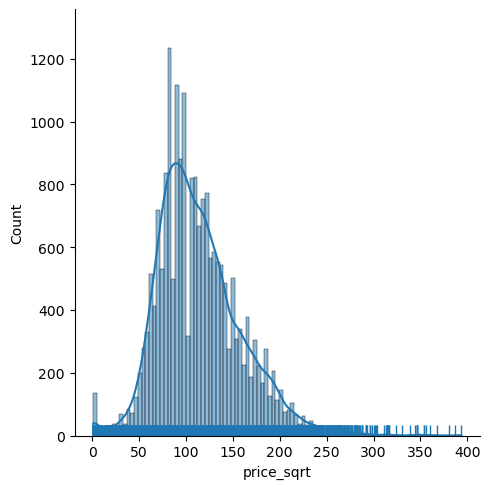

In [129]:
sns.displot(df["price_sqrt"], kde = True, rug = True)

In [143]:
# Split data into training and testing sets

X = df.drop(columns=['price','price_sqrt'])
y = df['price_sqrt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16572, 80) (4143, 80) (16572,) (4143,)


In [144]:
df.head(5)

,price,year,odometer,state_ca,state_fl,state_ny,state_otther,manufacturer_ford,manufacturer_honda,manufacturer_nissan,...,type_truck,type_van,paint_color_black,paint_color_grey,paint_color_silver,paint_color_white,transmission_automatic,transmission_manual,transmission_other,price_sqrt
215,4000,2002.0,155000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,63.245553
219,2500,1995.0,110661.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,50.000000
268,9000,2008.0,56700.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,94.868330
337,8950,2011.0,164000.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,94.604440
338,4000,1972.0,88100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,63.245553


In [145]:
# Check for NaNs in y_train
print("Number of NaNs in y_train:", y_train.isnull().sum())

# Optionally, print rows where y_train is NaN to inspect
nan_indices = y_train.index[y_train.isnull()]
print("Rows in y_train with NaN values:")
print(df.loc[nan_indices])

Number of NaNs in y_train: 0
Rows in y_train with NaN values:
Empty DataFrame
Columns: [price, year, odometer, state_ca, state_fl, state_ny, state_otther, manufacturer_ford, manufacturer_honda, manufacturer_nissan, manufacturer_toyota, man_model_chevrolet-equinox, man_model_chevrolet-silverado 1500, man_model_chevrolet-silverado 2500hd, man_model_ford-escape, man_model_ford-explorer, man_model_ford-mustang, man_model_gmc-sierra 1500, man_model_honda-civic, man_model_honda-cr-v, man_model_jeep-grand cherokee, man_model_jeep-wrangler, man_model_otther, man_model_ram-1500, man_model_ram-2500, man_model_toyota-corolla, man_model_toyota-prius, man_model_toyota-rav4, man_model_toyota-tacoma, region_central NJ, region_colorado springs, region_minneapolis / st paul, region_omaha / council bluffs, region_otther, region_vermont, condition_excellent, condition_fair, condition_good, condition_like new, condition_new, condition_salvage, cylinders_10 cylinders, cylinders_12 cylinders, cylinders_3 cy

In [146]:
# FEATURES SELECTION

# Pipeline for Ridge Regression
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=65.79))
])

# Pipeline for Sequential Feature Selection (SFS) with Lasso
sfs_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sfs', SequentialFeatureSelector(estimator=Lasso(alpha=1.0), n_features_to_select=5, direction='backward'))
])

# Pipeline for Recursive Feature Elimination (RFE) with Lasso
rfe_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfe', RFE(estimator=Lasso(alpha=1.0), n_features_to_select=5))
])


In [147]:
# Fit Ridge regression and extract coefficients
ridge_pipeline.fit(X_train, y_train)
ridge_coefs = ridge_pipeline.named_steps['ridge'].coef_

# Count non-zero coefficients (features with positive ridge coefficient)
ridge_features = np.count_nonzero(ridge_coefs > 0)

# Get selected features from Ridge pipeline
selected_features_ridge = X_train.columns[ridge_coefs > 0]

# Evaluate Ridge regression model
ridge_predictions = ridge_pipeline.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_r2 = r2_score(y_test, ridge_predictions)

# Fit Sequential Feature Selection (SFS) and extract selected features
sfs_pipeline.fit(X_train, y_train)
selected_features_sfs = X_train.columns[sfs_pipeline.named_steps['sfs'].get_support()]

# Fit Recursive Feature Elimination (RFE) and extract selected features
rfe_pipeline.fit(X_train, y_train)
selected_features_rfe = X_train.columns[rfe_pipeline.named_steps['rfe'].support_]

# Print results
print("Ridge Regression Coefficients:")
print(pd.Series(ridge_coefs, index=X_train.columns).sort_values())
print("\nNumber of features with positive Ridge coefficients:", ridge_features)
print("\nSelected features using Ridge Regression:")
print(selected_features_ridge)
print("\nRidge Regression MSE:", ridge_mse)
print("Ridge Regression R-squared:", ridge_r2)

print("\n\nSequential Feature Selection Coefficients:")
print("\nSelected features using Sequential Feature Selection (SFS):", selected_features_sfs)

print("\nSelected features using RFE:")
print(selected_features_rfe)


Ridge Regression Coefficients:
odometer                 -7.408072
drive_fwd                -4.996445
type_sedan               -4.581640
condition_fair           -4.402247
condition_good           -3.929553
                           ...    
type_truck                4.563977
condition_like new        4.985388
cylinders_8 cylinders     5.061142
fuel_diesel               6.611401
year                     14.921209
Length: 80, dtype: float64

Number of features with positive Ridge coefficients: 39

Selected features using Ridge Regression:
Index(['year', 'state_ca', 'state_otther', 'manufacturer_ford',
       'manufacturer_honda', 'manufacturer_toyota',
       'man_model_chevrolet-silverado 2500hd', 'man_model_ford-explorer',
       'man_model_gmc-sierra 1500', 'man_model_jeep-wrangler',
       'man_model_ram-2500', 'man_model_toyota-tacoma',
       'region_omaha / council bluffs', 'region_otther', 'region_vermont',
       'condition_excellent', 'condition_like new', 'condition_new',
    

In [148]:
# Using linear regression model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extracting selected features based on Ridge coefficients and p-value condition
selected_features = selected_features_ridge  # Use selected_features_ridge which meets the condition

# Prepare X_train and X_test with only selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Fit Linear Regression model
lm = LinearRegression()
lm.fit(X_train_selected, y_train)  # y_train is sqrt transformed

coefficients = lm.coef_

# Predictions
y_pred = lm.predict(X_test_selected)

# Inverse transform predictions to get back to original scale
y_pred_original_scale = y_pred ** 2  # y_train was sqrt transformed

# Model evaluation on original scale
mse = mean_squared_error(y_test ** 2, y_pred_original_scale)
rmse = np.sqrt(mse)
r2 = r2_score(y_test ** 2, y_pred_original_scale)

# Print parameter estimates and statistics using statsmodels for p-values
X_train_selected_with_constant = sm.add_constant(X_train_selected)
lm_stats = sm.OLS(y_train, X_train_selected_with_constant).fit()

# Combine parameter estimates, p-values, and F-statistic into a DataFrame for better output
results_df = pd.DataFrame({'Parameter Estimate': lm_stats.params, 'P-value': lm_stats.pvalues})
results_df.loc['F-statistic'] = [lm_stats.fvalue, lm_stats.f_pvalue]

# Print results
print("\nLinear Regression Parameter Estimates and P-values:")
print(results_df)

# Print evaluation metrics
print("\nMean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r2)

# Print model equation with intercept
intercept = lm.intercept_
equation = f"y = {intercept:.4f} + " + " + ".join([f"({lm.coef_[i]:.4f} * {feature})" for i, feature in enumerate(selected_features)])
print("\nModel Equation:")
print(equation)

lr_mse = mse
lr_r2 = r2
lr_f_value = lm_stats.fvalue
lr_f_pvalue = lm_stats.f_pvalue

# Count non-zero coefficients
lr_features = np.count_nonzero(coefficients)


Linear Regression Parameter Estimates and P-values:
                                      Parameter Estimate        P-value
const                                       -4077.285244   0.000000e+00
year                                            2.054820   0.000000e+00
state_ca                                       10.889365   9.590331e-25
state_otther                                    7.556258   1.859263e-22
manufacturer_ford                               1.450545   5.194008e-02
manufacturer_honda                              0.719585   5.084419e-01
manufacturer_toyota                             4.191103   1.307399e-05
man_model_chevrolet-silverado 2500hd           10.745068   2.805798e-03
man_model_ford-explorer                         6.727577   6.229300e-02
man_model_gmc-sierra 1500                       5.814477   7.870675e-02
man_model_jeep-wrangler                        31.493901   1.144733e-22
man_model_ram-2500                             12.896251   2.457212e-04
man_model_t

In [149]:
# Sequential Feature Selection (SFS)

X = df[selected_features_sfs]
y = df['price_sqrt']   

# Step 1: Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Fit the model using the modified training set
model = LinearRegression()
model.fit(X_train, y_train)

# Get parameter estimates (coefficients) and p-values
coefficients = model.coef_
intercept = model.intercept_

# Perform OLS regression using statsmodels to get p-values
X_train_with_intercept = sm.add_constant(X_train)  # Add intercept term
model_sm = sm.OLS(y_train, X_train_with_intercept).fit()
p_values = model_sm.pvalues

f_value = model_sm.fvalue
f_pvalue = model_sm.f_pvalue  # F-test p-value

r_squared = model_sm.rsquared
adj_r_squared = model_sm.rsquared_adj

# Predict on the test set
#y_test_pred = model.predict(X_test)
y_test_pred_sqrt = model.predict(X_test)
y_test_pred = y_test_pred_sqrt ** 2  # Inverse transform from sqrt scale to original scale


test_mse = mean_squared_error(y_test, y_test_pred)

# Make predictions on the validation set
#y_val_pred = model.predict(X_val)
y_val_pred_sqrt = model.predict(X_val)
y_val_pred = y_val_pred_sqrt ** 2  # Inverse transform from sqrt scale to original scale

# Calculate Mean Squared Error (MSE)
val_mse = mean_squared_error(y_val, y_val_pred)

# Output parameter estimates, p-values, equation, and MSE
print("SFS Parameter Estimates:")
for feature, coef, p_value in zip(X_train.columns, coefficients, p_values):
    print(f"{feature}: Coef = {coef:.4f}, p-value = {p_value:.4f}")
print(f"Intercept: {intercept:.4f}")

# Construct the equation
equation = f"y = {intercept:.4f} + "
for feature, coef in zip(X_train.columns, coefficients):
    equation += f"({coef:.4f} * {feature}) + "
equation = equation[:-3]  # Remove the trailing '+'

print("\nR-squared:", r_squared)
print("  Adjusted R-squared:", adj_r_squared)

print("F-value:", f_value)
print("F-test p-value:", f_pvalue)

print(f"\nEquation: {equation}")
print(f"Mean Squared Error (MSE) on Validation Set: {val_mse:.4f}")
print(f"Mean Squared Error (MSE) on Test Set: {test_mse:.4f}")

sfs_test_mse = test_mse
sfs_r_squared = r_squared
sfs_f_value = f_value
sfs_f_pvalue = f_pvalue

# Count non-zero coefficients
sfs_features = np.count_nonzero(coefficients)

SFS Parameter Estimates:
year: Coef = 2.0299, p-value = 0.0000
odometer: Coef = -0.0001, p-value = 0.0000
cylinders_8 cylinders: Coef = 21.2983, p-value = 0.0000
fuel_diesel: Coef = 41.4960, p-value = 0.0000
drive_fwd: Coef = -25.6058, p-value = 0.0000
Intercept: -3958.4818

R-squared: 0.38334968659409374
  Adjusted R-squared: 0.3831014976246798
F-value: 1544.5879303149363
F-test p-value: 0.0

Equation: y = -3958.4818 + (2.0299 * year) + (-0.0001 * odometer) + (21.2983 * cylinders_8 cylinders) + (41.4960 * fuel_diesel) + (-25.6058 * drive_fwd)
Mean Squared Error (MSE) on Validation Set: 220246314.2342
Mean Squared Error (MSE) on Test Set: 225879298.4003


In [150]:
# Compare MSE and R-squared of Ridge Regression with SFS
results = pd.DataFrame({
    'Method': ['Ridge Regression', 'Linear Regression', 'Sequential Feature Selection (SFS)'],
    'MSE': [ridge_mse, lr_mse, sfs_test_mse],        
    'R-squared': [ridge_r2, lr_r2, sfs_r_squared],  
    'N-Features': [ridge_features, lr_features, sfs_features]      
})

# Display results
print("\nComparison of Models:")
print(results)



Comparison of Models:
                               Method           MSE  R-squared  N-Features
0                    Ridge Regression  9.679226e+02   0.517417          39
1                   Linear Regression  7.977336e+07   0.458215          39
2  Sequential Feature Selection (SFS)  2.258793e+08   0.383350           5


Final Model selected:

Linear Regression Model Equation:
Used Car Price ($) = -4077.2852 + (2.0548 * year) + (10.8894 * state_ca) + (7.5563 * state_otther) + (1.4505 * manufacturer_ford) + (0.7196 * manufacturer_honda) + (4.1911 * manufacturer_toyota) + (10.7451 * man_model_chevrolet-silverado 2500hd) + (6.7276 * man_model_ford-explorer) + (5.8145 * man_model_gmc-sierra 1500) + (31.4939 * man_model_jeep-wrangler) + (12.8963 * man_model_ram-2500) + (12.6014 * man_model_toyota-tacoma) + (6.0485 * region_omaha / council bluffs) + (5.2176 * region_otther) + (14.9004 * region_vermont) + (14.2196 * condition_excellent) + (28.1359 * condition_like new) + (45.6303 * condition_new) + (18.5624 * cylinders_12 cylinders) + (13.9924 * cylinders_8 cylinders) + (0.5488 * cylinders_other) + (31.2491 * fuel_diesel) + (25.4384 * fuel_electric) + (3.0587 * fuel_hybrid) + (13.6184 * title_status_lien) + (3.3580 * title_status_parts only) + (11.8520 * size_full-size) + (7.8291 * size_mid-size) + (21.9568 * drive_4wd) + (17.1178 * drive_rwd) + (28.7832 * type_convertible) + (24.2632 * type_coupe) + (13.0667 * type_pickup) + (18.1874 * type_truck) + (14.2177 * type_van) + (4.4473 * paint_color_black) + (2.6657 * paint_color_grey) + (3.5569 * paint_color_white) + (8.2881 * transmission_manual)


Interpretation:
The P-value of 0.00 associated with the F-statistics indicates that the overall model is significant. 

Each coefficient in the model equation provides insight into how different factors influence the price of used cars. In the real world, a combination of factors (higher dimensional factors) interact together to  influence the price of used cars. For easier interpretability and in absence of resources, complex interactions or patterns were not explored and are reserved for machine learning models. 

Interpretation of a few Predictor Variables:

Year (2.0548): Newer cars are associated with an increase of approximately 2,054.80 in its price.
State of California (10.8894): Cars located in California (state_ca) have a higher price by 10,889.40 compared to cars in other states.

Manufacturer Toyota (4.1911): Cars manufactured by Toyota have a higher price by 4,191.10 compared to other manufacturers like Toyota.

Specific Car Models:
Chevrolet Silverado 2500HD (10,745.10); Jeep Wrangler (31,493.90); Ram 2500 (12,896.30) and Toyota Tacoma (12,601.40) have higher prices compared to other models.

Geographical Regions:
Besides California, cars located in Omaha/Council Bluffs (6,048.50) and Vermont (14,900.40) have a higher price compared to other regions.

Condition:
Cars in Excellent Condition (14,219.60); Like New Condition (28,135.90) or New Condition (45,630.30) tend to have a higher price compared to caars in other conditions.


Cylinders:
12 Cylinders (18.5624): Cars with 12 cylinders have a higher price by 18,562.40 compared to other cylinder configurations while cars with 8 cylinders have a higher price by 13,992.40 compared to other cylinder configurations.

Fuel Type:
Diesel-powered cars (31,249.1) and Electric cars (25,438.4) have a higher price compared to other fuel types.

Title Status:
Cars with a lien title status have a higher price by 13,618.40 compared to other title statuses 


Size:
Full-size cars have a higher price by 11,852.00 compared to other sizes while mid-size cars have a higher price by 7,829.10 compared to other sizes.

Drive Type:
Four-wheel-drive cars have a higher price by 21,956.80 compared to other drive types while Rear-wheel-drive cars have a higher price by 17,117.80 compared to other drive types.

Vehicle Type:
Convertible (28.7832): Convertible cars have a higher price by 28,783.20 compared to other vehicle types.
Coupe (24.2632): Coupe cars have a higher price by 24,263.20 compared to other vehicle types.
Pickup (13.0667): Pickup trucks have a higher price by 13,066.70 compared to other vehicle types.
Truck (18.1874): Trucks have a higher price by 18,187.40 compared to other vehicle types.
Van (14.2177): Vans have a higher price by 14,217.70 compared to other vehicle types.

Paint Color:
Black (4.4473): Cars painted black have a higher price by 4,447.30 compared to other colors.
Grey (2.6657): Cars painted grey have a higher price by 2,665.70 compared to other colors.
White (3.5569): Cars painted white have a higher price by 3,556.90 compared to other colors.

Transmission Type:
Manual Transmission (8.2881): Cars with manual transmission have a higher price by 8,288.10 compared to other transmission types.


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

R-squared value of 0.4582 indicates that approximately 45.82% of the variability in the price can be explained by the predictors included in the model.

RMSE of approximately 8931.59 suggests that, on average, price predictions deviate from the actual values by around 8931.59 units.


In [151]:
# Use the Linear Regression model to make predictions
y_pred = y_pred_original_scale

# Create a DataFrame to show actual vs. predicted values
actual_vs_predicted_df = pd.DataFrame({'Actual': y_test**2, 'Predicted': y_pred})
actual_vs_predicted_df.head(10)

,Actual,Predicted
52989,8995.0,10268.463359
15984,11990.0,10350.671704
109628,13995.0,18257.182155
379287,5995.0,10920.760064
73790,12000.0,8561.167891
168880,22999.0,23713.443251
266340,7995.0,11286.169115
83509,4995.0,6621.484948
331614,7988.0,9964.815758
121801,16000.0,11233.537699


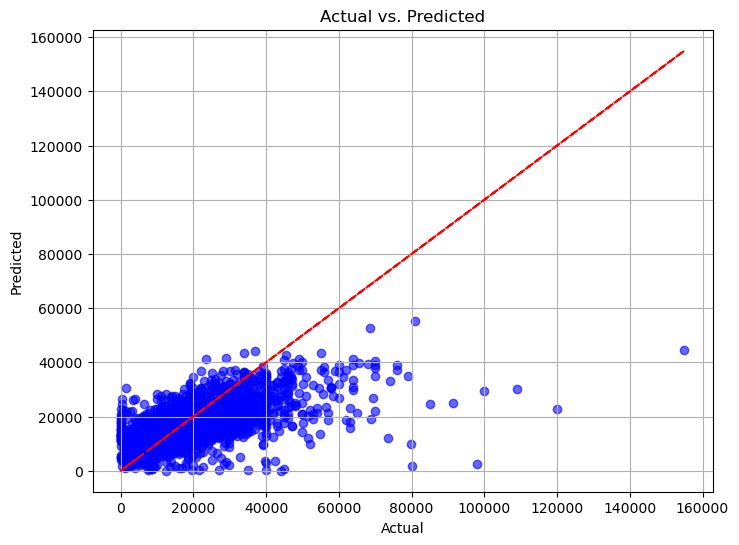

In [152]:
# Scatter plot of Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(actual_vs_predicted_df['Actual'], actual_vs_predicted_df['Predicted'], color='blue', alpha=0.6)
plt.plot(actual_vs_predicted_df['Actual'], actual_vs_predicted_df['Actual'], color='red', linestyle='--')  # Perfect prediction line
plt.title('Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.show()

In [153]:
# Calculate residuals
residuals = actual_vs_predicted_df['Actual'] - actual_vs_predicted_df['Predicted']

# Add residuals to the DataFrame for further analysis
actual_vs_predicted_df['Residuals'] = residuals

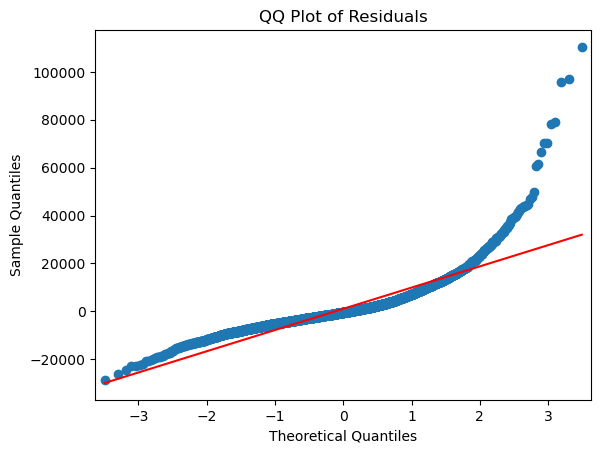

In [154]:
import statsmodels.api as sm
import scipy.stats as stats

# Plot QQ plot of residuals
sm.qqplot(residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.show()


In [155]:
# Shapiro-Wilk test for normality of residuals
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test Statistic: {shapiro_test.statistic:.4f}")
print(f"P-value: {shapiro_test.pvalue:.4f}")


Shapiro-Wilk Test Statistic: 0.8119
P-value: 0.0000


Deviation of the residuals from the red line indicates the model's inaccuracies. 

In [156]:
from scipy import stats

# Perform one-sample t-test
t_statistic, p_value = stats.ttest_1samp(residuals, 0)

print(f"T-test Statistic: {t_statistic}")
print(f"P-value: {p_value}")

T-test Statistic: 7.731711832806281
P-value: 1.3232026032281208e-14


The t-test statistic of 7.73 indicates a substantial difference between the predicted and actual values. The regression model's predictions are statistically biased hence the need to investigate specific areas where the model tends to perform poorly and explore potential reasons behind the biases observed. A few of the suggestions may include: exclusion of outliers; fitting manufacturer-based models; car model-based models; or geographical-based models.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Report on Used Car Price Prediction Model and Findings

Used car dealers rely heavily on accurate pricing models to optimize their inventory management and maximize profitability. This report presents the findings from our analysis and development of a predictive model for used car prices. Our goal was to provide insights into factors influencing car prices and deliver a robust model for deployment.

We used a comprehensive dataset that included information such as car specifications (year of make, odometer, model), condition, geographical location, and more. The dataset was preprocessed to handle missing values, drop duplicated records, encode categorical variables, and transform the target variable (price) as necessary.

Ridge Regression for feature selection to mitigate multicollinearity issues and enhance model performance was employed. Selected features with a non-zero coefficients where modeled with Linear Regression due to its interpretability and ability to capture linear relationships between predictors and price. Model performance was assessed using Root Mean Squared Error (RMSE), and R-squared. 

Primary Findings
1.	Impactful Factors:
o	Year: Newer cars tend to have higher prices. 
o	Geographical Factors: Cars in California have a higher price, while specific regions and states also influence pricing significantly.
o	Condition and Model: New or like-new conditions, specific models (e.g., Jeep Wrangler), and manufacturers (e.g., Toyota) command higher prices.

2.	Recommendations for Dealers:
o	Regional Pricing Strategy: Consider adjusting prices based on regional demand and economic factors.
o	Inventory Optimization: Focus on models and conditions that yield higher prices.
o	Marketing Strategies: Highlight features like low mileage, newer models, or popular brands to attract buyers.

3.	Model Limitations:
o	Outliers: Address outliers that can skew predictions and affect model accuracy.
o	Model Bias: Further investigate biases in predictions across different car manufacturers or geographical regions.

Deployment and Next Steps
o	Deployment: Deploy the developed model to automate pricing decisions and enhance inventory management.
o	Monitoring: Continuously monitor model performance and update it with new data to maintain accuracy.
o	Feedback Loop: Gather feedback from dealers to improve model insights and predictions over time.

Conclusion The developed model provides a reliable framework for predicting used car prices based on various influential factors. By leveraging this model, dealers can optimize their pricing strategies, improve inventory turnover, and ultimately enhance profitability. Continued refinement and adaptation of the model will ensure its relevance and effectiveness in the dynamic used car market.
This report aims to empower used car dealers with actionable insights derived from data-driven analysis, enabling them to make informed decisions and stay competitive in the industry.


References
 [1] "A Beginner's Guide to Kaggle for Data Science". MUO. 2023-04-17. Retrieved 2023-06-10.